In [87]:
import os
import pathlib

print(f"Current directory: {os.getcwd()}")

path_dataset = pathlib.Path("../dataset/")

Current directory: /Users/longyyu/Documents/research/recipevis.git/src


In [4]:
def download_resource(resource_url, local_path):
    import requests
    if not os.path.exists(local_path):
        r = requests.get(resource_url)
        print(f"Content type: {r.headers.get('content-type')}")
        print(f"Content disposition: {r.headers.get('content-disposition')}")
        print(f"Content length: {r.headers.get('content-length')}")
        try:
            with open(local_path, 'wb') as file_disk:
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        file_disk.write(chunk)
        except Exception as e:
            print(f"Error: {str(e)}")
        if os.path.isfile(local_path):
            print("Downloaded successfully!")
    else:
        print(f"Resource {local_path} already exists.")

## BBC Good Food

* JSON format recipes from this [github repo](https://github.com/mneedham/bbcgoodfood). There is no documentation on the original source of data, but it seems like data come from this [web scraping script](https://github.com/mneedham/bbcgoodfood/blob/master/download_recipes.py). The url list is unknown. 
* See also https://www.bbcgoodfood.com/. 

In [119]:
filename_dataset = "bbcgoodfood.json"
download_resource(
    resource_url="https://github.com/mneedham/bbcgoodfood/raw/master/stream_clean.json",
    local_path=str(path_dataset/filename_dataset)
)
# read in the json file
import json
data = []
with open(path_dataset/filename_dataset, 'r') as f:
    for line in f:
        data.append(json.loads(line))

print(f"Num of recipes: {len(data)}")
print("Keys of an element: ", data[0].keys())


Resource ../dataset/bbcgoodfood.json already exists.


* The data is a list of dictionary objects, and each dictionary has only one key 'page'. 
    * Each 'page' is also a dictionary, with keys ['article', 'recipe', 'channel', 'title'].
        * Channel is just 'Recipe'.  
        * Article is again a dictionary, with keys ['author', 'description', 'id', 'tags']. 
        * Recipe, another dictionary, has keys ['collections', 'cooking_time', 'prep_time', 'serves', 'keywords', 'ratings', 'nutrition_info', 'ingredients', 'courses', 'cusine', 'diet_types', 'skill_level', 'post_dates']. 
            - Collections: tags such as `Bakewell tart, 200-400 calorie, Easy Christmas, Eat like an athlete, Thai, Blackberry, Summer soup, Autumn cake, Sponge cake, Omelette, Salmon, Chickpea, Microwave pudding, Prosecco, Low in salt, Christmas Day drinks, Healthy pie, Easy cocktail`. 
            - Keywords: key ingredients and tags such as `Stewing steak, Bucks fizz, Vegetarian bbq, Devilled mushrooms, Packed lunch, chickpea side dish, oat and fruit bars, Vanilla sponge, Smart supper, Summer fruit, healthy gravy, Merrilees Parker, Chilled pudding, Gordon ramsay recipes`. 
            - Cusine (45): `French, Scottish, Thai, Greek, African, Cuban, Middle Eastern, Italian, Cajun & Creole, Eastern European, Australian, English, Asian, Swiss, Caribbean, Japanese, Korean, American, Chinese, Latin American, Brazilian, Turkish, Irish, Belgian, Indonesian, British, Indian, Scandinavian, Balinese, Spanish, German, Mediterranean, Danish, Tunisian, Moroccan, Mexican, Swedish, Portuguese, Austrian, Chilean, Jewish, North African, Southern & Soul, Vietnamese, Hungarian`. 
            - Courses (22): `Starter, Supper, Cheese Course, Canapes, Condiment, Side dish, Main course, Afternoon tea, Soup course, Vegetable course, Fish Course, Lunch, Buffet, Breakfast, Cocktails, Snack, Dinner, Brunch, Drink, Dessert, Pasta course, Treat`. 

In [211]:
import pandas as pd
cols = ['article_id', 'title', 'ratings', 'serves', 'ingredients', 'cusine', 'courses']
data_df = pd.DataFrame(columns=cols)
for item in data:
    page = item['page']
    recipe = page['recipe']
    data_df = data_df.append(
        pd.DataFrame(
            data=[[page['article']['id'], page['title'], recipe['ratings'], recipe['serves'], recipe['ingredients'], recipe['cusine'], recipe['courses']]],
            columns=cols
        )
    )
data_df = data_df.reset_index(drop=True)

### A closer look at the pizza recipes

#### Filtering pizza recipes

I first filtered the recipes with "pizza" in their titles, which yields 118 results. Then I manually examined the recipe titles to drop non-pizza recipes and label as much pizza subcategories as I can: 
* Non-pizza: 'Steak with pizzaiola sauce', '5 easy pizza toppings', ['Pizza omelette'](https://www.bbcgoodfood.com/recipes/pizza-omelette), ['Baked cauliflower pizzaiola'](https://www.bbcgoodfood.com/recipes/baked-cauliflower-pizzaiola), ['Pizza baked potato'](https://www.bbcgoodfood.com/recipes/pizza-baked-potato), ['Puff pizza tart'](https://www.bbcgoodfood.com/recipes/puff-pizza-tart), ['Mini pizza quiches'](https://www.bbcgoodfood.com/recipes/mini-pizza-quiches), ['Pizzadillas'](https://www.bbcgoodfood.com/recipes/pizzadillas), and ['Pizza pasta salad'](https://www.bbcgoodfood.com/recipes/pizza-pasta-salad)
* Margherita pizza, e.g. 'Next level Margherita pizza', 'Very simple Margherita pizza', 'Ultimate pizza Margherita', 'Pizza Margherita in 4 easy steps', 'Lighter Pizza Margherita'
* Florentine pizza: 'Florentine pizza', '20-minute Fiorentina pizzas', 'Florentine dairy-free pizza', 'Eggs Florentine pizza'
* Deep-pan pizza: 'Cheat's deep-pan pizza'
* Frying pan pizza: 'Frying pan pizza bianco with mushrooms & egg', 'Frying pan pizza with aubergine, ricotta & mint', 'Frying pan pizza', 'Frying pan pizza pie'
* Others: 'Mini top-your-own pizzas', 'Pesto pizza with artichokes & prosciutto'

In this process, I also identified some potential outliers: ['Cookie dough pizza'](https://www.bbcgoodfood.com/recipes/cookie-dough-pizza), ['Cauliflower crust pizza'](https://www.bbcgoodfood.com/recipes/cauliflower-crust-pizza), ['Tuna melt pizza baguettes'](https://www.bbcgoodfood.com/recipes/tuna-melt-pizza-baguettes).

In [409]:
df_pizza = data_df[data_df.title.str.lower().str.contains("pizza")].reset_index(drop = True)
print(f"Before: {df_pizza.shape[0]}")

# drop the non-pizza recipes
list_nonpizza = ['Steak with pizzaiola sauce', '5 easy pizza toppings', 'Pizza omelette', 'Baked cauliflower pizzaiola', 'Pizza baked potato', 'Puff pizza tart', 'Mini pizza quiches', 'Pizzadillas', 'Pizza pasta salad']
df_pizza = df_pizza[~df_pizza.title.isin(list_nonpizza)].reset_index(drop = True)

# label the rest
df_pizza["category"] = None
df_pizza.loc[df_pizza.title.str.contains("Margherita"), "category"] = "Margherita"
df_pizza.loc[df_pizza.title.str.contains("Florentine|Florentina|Fiorentina", regex=True), "category"] = "Florentine"
df_pizza.loc[df_pizza.title.str.contains("Frying pan"), "category"] = "Frying-pan"
df_pizza.loc[df_pizza.title.str.contains("deep-pan"), "category"] = "Deep-pan"

print(f"After: {df_pizza.shape[0]}")
print(df_pizza.groupby("category")["category"].count())

df_pizza.head()

Before: 118
After: 109
category
Deep-pan      1
Florentine    4
Frying-pan    4
Margherita    5
Name: category, dtype: int64


,article_id,title,ratings,serves,ingredients,cusine,courses,category
0,102136,Pizza puff pinwheels,92,12,"[puff pastry, pasta, ham, cheddar, egg, oregano]",Italian,"[Treat, Starter, Snack, Afternoon tea]",None
1,4278386,Smoking chilli chicken & sweetcorn pizza,100,4,"[barbecue sauce, chipotle paste, pizza base, m...",,[Main course],None
2,7829316,Next level Margherita pizza,100,0,"[strong white flour, fast-action dried yeast, ...",,"[Dinner, Lunch, Main course]",Margherita
3,96966,Very simple Margherita pizza,98,2,"[olive oil, plain flour, yeast, sugar, water, ...",Italian,"[Dinner, Main course]",Margherita
4,3410721,Holiday pizzas,93,0,"[bread flour, sugar, fast-action dried yeast, ...",Italian,[Main course],None


The original recipe with article_id [4278386](https://www.bbcgoodfood.com/recipes/smoking-chilli-chicken-sweetcorn-pizza):

* 100g barbecue sauce
* 1-2 tbsp chipotle paste , or more if you like it spicy
* 2 large ready-made pizza bases
* 175g mozzarella , grated (ready-grated is fine)
* 200g can sweetcorn , drained
* 300g jar red pepper , drained and torn into slices
* 200g cooked sliced chicken
* small pack coriander , leaves only
* 2 fat green chillies , sliced, seeds removed (optional)

#### Ingredient list cleanup

This dataset already comes with pre-processed ingredient lists with the measuring units and most of the descriptive terms removed. But there is still room for further clean-up, e.g., 'strong white flour' -> 'flour'. I manually created a set of mapping rules to aggregate ingredients (see `src/ingredient_mapper.json`), reducing the number of unique ingredients from 270 to 194.  

**Question**
* Granularity
    - Should we treat "pizza base" and "pizza base mix" as the same? What about "pizza base mix" and "bread mix"?
    - Brown sugar and regular sugar? Balsamic vinegar and red wine vinegar?
    - 'olive oil' -> 'oil'? 'tomato sauce' -> 'tomato'?
* How to automatically generate these mapping rules?

In [435]:
with open("ingredient_mapper.json", "r") as f:
    ingredient_mapper = json.load(f)
# print(json.dumps(ingredient_mapper, indent=4))

from itertools import chain
from collections import defaultdict
print("Num of unique ingredients (before cleaning): ", len(set(chain.from_iterable(df_pizza["ingredients"]))))

# further clean up the ingredients
df_pizza["ingredients_cleaned"] = [
    list(set([ingredient_mapper.get(item, item) for item in ing_list])) \
        for ing_list in df_pizza["ingredients"]
]
# row-to-row comparison
for i in range(5):
    print(f">>> {','.join(df_pizza.ingredients[i])}\n<<< {','.join(df_pizza.ingredients_cleaned[i])}\n")

# compute frequency table
ingredients = defaultdict(int)
for item in chain.from_iterable(df_pizza["ingredients_cleaned"]):
    ingredients[item] += 1

df_ingredients = pd.DataFrame.from_dict(ingredients, orient = "index", columns=["freq"])\
    .sort_values(by="freq", ascending=False).reset_index().rename(columns={'index': 'ingredient'})

print(f"Num of unique ingredients (after cleaning): {len(df_ingredients)}")
df_ingredients.head(10)

# df_ingredients[df_ingredients['ingredient'].str.contains('potato')].ingredient.tolist()

Num of unique ingredients (before cleaning):  270
>>> puff pastry,pasta,ham,cheddar,egg,oregano
<<< cheddar,pasta,ham,oregano,egg,puff pastry

>>> barbecue sauce,chipotle paste,pizza base,mozzarella,sweetcorn,red pepper,chicken,coriander,green chilli
<<< mozzarella,sweetcorn,chicken,barbecue sauce,red pepper,pizza base,chipotle paste,coriander,chilli

>>> strong white flour,fast-action dried yeast,plum tomatoes,extra virgin olive oil,oregano,basil,parmesan,mozzarella
<<< oil,mozzarella,parmesan,flour,basil,tomato,oregano,yeast

>>> olive oil,plain flour,yeast,sugar,water,passata,mozzarella,parmesan,basil,salad
<<< oil,mozzarella,passata,salad,parmesan,flour,sugar,basil,yeast,water

>>> bread flour,sugar,fast-action dried yeast,olive oil,water,garlic clove,passata,tomato purÃ©e,oregano,basil leaf,sugar,red wine vinegar,mozzarella,houmous
<<< oil,mozzarella,garlic clove,passata,houmous,flour,sugar,tomato,basil,red wine vinegar,oregano,yeast,water

Num of unique ingredients (after cleanin

,ingredient,freq
0,oil,75
1,tomato,54
2,flour,51
3,mozzarella,49
4,garlic clove,37
5,yeast,33
6,onion,32
7,basil,29
8,bread,22
9,olive,19


In [485]:
from collections import Counter
from itertools import combinations
# create a dictionary that counts the occurrences of each ingredient pair
combi_count = dict(Counter(
    chain.from_iterable([
        list(combinations(sorted(ing_list), 2)) for ing_list in df_pizza.ingredients_cleaned
    ])
))
sorted(combi_count.items(), key=lambda item: item[1], reverse=True)[:10]

[(('flour', 'oil'), 44),
 (('oil', 'tomato'), 41),
 (('garlic clove', 'oil'), 35),
 (('mozzarella', 'tomato'), 34),
 (('oil', 'yeast'), 33),
 (('flour', 'yeast'), 32),
 (('mozzarella', 'oil'), 32),
 (('flour', 'tomato'), 29),
 (('flour', 'mozzarella'), 25),
 (('flour', 'garlic clove'), 25)]

#### Visualization attempts

##### Bar/Pie Charts

Select several main ingredients to plot proportion?

* Refer to [Baking with machine learning](https://sararobinson.dev/2020/04/30/baking-machine-learning.html) - 12 main ingredients: flour, sugar, starter, salt, yeast, milk, water, oil, eggs, baking powder, baking soda, butter.

Problem is the current dataset **does not have quantity information.**

In [430]:
major_ingredients = ["flour", "sugar", "salt", "yeast", "milk", "water", "oil", "egg", "baking powder", "butter"]

['potato', 'new potato', 'Jersey Royal potato']

##### Network Graphs

In [413]:
import matplotlib.pyplot as plt
import networkx as nx
import nx_altair as nxa

Num of edges:  41
Num of nodes:  16


alt.LayerChart(...)

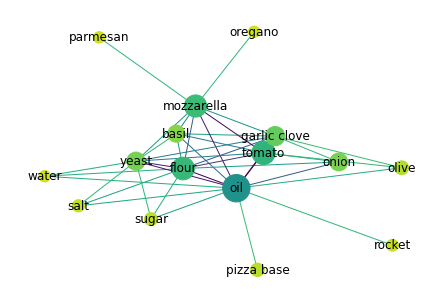

In [636]:
G = nx.Graph()
# G.add_edges_from(combi_count.keys())
G.add_edges_from([item[0] for item in combi_count.items() if item[1] > 10])
print("Num of edges: ", G.number_of_edges())
print("Num of nodes: ", G.number_of_nodes())

for edge in G.edges():
    occurrence = combi_count[edge] if edge in combi_count else combi_count[(edge[1], edge[0])]
    G.edges()[edge].update({
        "edge_weight": occurrence
    })

for node in G.nodes():
    G.nodes()[node].update({
        "label": node,
        "weight": ingredients[node]
    })

# draw the graph using networkx (matplotlib)
weights = [ingredients[node] for node in G.nodes()]
widths = [G.edges()[edge]['edge_weight'] for edge in G.edges()]
nx.draw(
    G, with_labels=True, pos=nx.spring_layout(G, seed=23),
    node_size=np.array(weights)*10, node_color=weights, cmap=plt.cm.viridis_r, vmin=2, vmax=150,
    edge_color=widths, edge_cmap=plt.cm.viridis_r, edge_vmin=0, edge_vmax=35
)

# draw the graph using nx-altair
viz = nxa.draw_networkx(
    G,
    node_label='label',
    node_color='weight', cmap='blues',
    pos=nx.spring_layout(G, seed=23),
    width='edge_weight',
    edge_color="#5D8AA8",
)
viz.interactive()

## Annotated recipes from ["RecipeScape"](https://recipescape.kixlab.org/)

Annotated recipes in JSON format for [chocolate chip cookies](https://recipescape.kixlab.org/ccc_trees.json) and [tomato pasta](https://recipescape.kixlab.org/tomatopasta_trees.json).

In [13]:
# download dataset from url if not already exists
filename_dataset = "recipescape-choco-chip-cookies.json"
download_resource(
    resource_url="https://recipescape.kixlab.org/ccc_trees.json",
    local_path=str(path_dataset/filename_dataset)
)
# read in the json file
import json
with open(path_dataset/filename_dataset, 'r') as f:
    data = json.load(f)
# data is a list of dict objects, each dict has keys 'id' and 'tree'

Resource dataset/recipescape-choco-chip-cookies.json already exists.


This dataset is a list of dict objects, each dict has keys 'id' and 'tree'.

In [42]:
print(f"Num of elements: {len(data)}")
print("Keys of an element: ", data[0].keys())
# print(json.dumps(data, indent=4))

Num of elements: 490
Keys of an element:  dict_keys(['id', 'tree'])


A 'tree' is also a list of dict objects, each with keys 'word' and 'ingredient'. 

In [45]:
tree = data[0]["tree"]
print(f"Num of elements: {len(tree)}")
print("Keys of an element: ", tree[0].keys())
# print(json.dumps(tree, indent=4))

Num of elements: 7
Keys of an element:  dict_keys(['word', 'ingredient'])


In [75]:
# pretty print the data as table (first 6 rows)
def print_row(row):
    print(f"{row[0]:<24}\t{row[1]:<12}\t{row[2]}")

print_row(["recipe_id", "word", "ingredient"])
for recipe in data[:6]:
    for idx, record in enumerate(recipe["tree"]):
        print_row(row=[' ' if idx else recipe['id'], record['word'], ','.join(record['ingredient'])])

recipe_id               	word        	ingredient
54a47bb66529d92b2c02c10e	arrange     	bread slices,work surface,bread slice,cheese,tablespoons caponata,half,tomato
                        	remaining   	cheese,bread,brush,bread slices,oil,heat,skillet,medium heat
                        	is          	cheese
54a42ff76529d92b2c01385a	heat        	cooking spray
                        	add         	tomato sauce,cranberry sauce,horseradish,dry mustard,vinegar,stock
                        	lower       	
                        	stirring    	
                        	lower       	
                        	serve       	
                        	reheat      	
54a4154d19925f464b375841	heat        	oil
                        	sauté       	shallots
                        	add         	chicken
                        	turn        	chicken
                        	broth       	
                        	cover       	
                        	simmer      	chicken
                        	boil     

### Tomato pasta

In [363]:
# download dataset from url if not already exists
filename_dataset = "recipescape-tomato-pasta.json"
download_resource(
    resource_url="https://recipescape.kixlab.org/tomatopasta_trees.json",
    local_path=str(path_dataset/filename_dataset)
)

# read in the json file
import json
with open(path_dataset/filename_dataset, 'r') as f:
    data = json.load(f)
# data is a list of dict objects, each dict has keys 'id' and 'tree'

print(f"Num of elements: {len(data)}")
print("Keys of an element: ", data[0].keys())
# print(json.dumps(data, indent=4))

tree = data[0]["tree"]
print(f"\nNum of elements: {len(tree)}")
print("Keys of an element: ", tree[0].keys())
# print(json.dumps(tree, indent=4))

Resource ../dataset/recipescape-tomato-pasta.json already exists.
Num of elements: 553
Keys of an element:  dict_keys(['id', 'tree'])

Num of elements: 3
Keys of an element:  dict_keys(['word', 'ingredient'])


In [365]:
# pretty print the data as table (first 6 rows)
def print_row(row):
    print(f"{row[0]:<24}\t{row[1]:<12}\t{row[2]}")

print_row(["recipe_id", "word", "ingredient"])
for recipe in data[:6]:
    for idx, record in enumerate(recipe["tree"]):
        print_row(row=[' ' if idx else recipe['id'], record['word'], ','.join(record['ingredient'])])

# pprint_df = pd.DataFrame(
#     columns = ["recipe_id", "word", "ingredient"]
# )
# for recipe in data:
#     for record in recipe["tree"]:
#         pprint_df = pprint_df.append(pd.DataFrame(
#             data=[[recipe["id"], record["word"], record["ingredient"]]],
#             columns=["recipe_id", "word", "ingredient"]
#         ))
# pprint_df.head()

recipe_id               	word        	ingredient
54a47bb66529d92b2c02c10e	arrange     	bread slices,work surface,bread slice,cheese,tablespoons caponata,half,tomato
                        	remaining   	cheese,bread,brush,bread slices,oil,heat,skillet,medium heat
                        	is          	cheese
54a42ff76529d92b2c01385a	heat        	cooking spray
                        	add         	tomato sauce,cranberry sauce,horseradish,dry mustard,vinegar,stock
                        	lower       	
                        	stirring    	
                        	lower       	
                        	serve       	
                        	reheat      	
54a4154d19925f464b375841	heat        	oil
                        	sauté       	shallots
                        	add         	chicken
                        	turn        	chicken
                        	broth       	
                        	cover       	
                        	simmer      	chicken
                        	boil     

## Simplified Recipes1M

> Source: https://dominikschmidt.xyz/simplified-recipes-1M/

In [88]:
# download dataset from url if not already exists
filename_dataset = "simplified-recipes-1M.npz"
download_resource(
    resource_url="https://github.com/schmidtdominik/RecipeNet/raw/master/simplified-recipes-1M.npz",
    local_path=str(path_dataset/filename_dataset)
)

import numpy as np
with np.load(path_dataset/filename_dataset, allow_pickle=True) as data:
    recipes = data['recipes']
    ingredients = data['ingredients']
del data

Resource ../dataset/simplified-recipes-1M.npz already exists.
